<a href="https://colab.research.google.com/github/Debrup-61/SENTIMENTANALYSISUSINGLSTM/blob/main/Assignment2_LSTM_19MA20061.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np       # linear algebra
import pandas as pd      # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords     #stopwords
import nltk
nltk.download('stopwords')
from collections import Counter
import string
import re                             #regular expression library
import seaborn as sns                 #seaborn library
from tqdm import tqdm
import matplotlib.pyplot as plt      
from torch.utils.data import TensorDataset, DataLoader           #dataloader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



CHECKING IF GPU IS AVAILABLE

In [ ]:
is_cuda=torch.cuda.is_available()

if is_cuda:
  device=torch.device("cuda")
  print("GPU IS AVAILABLE")
else:
  device=torch.device("cpu")
  print("GPU NOT AVAILABLE,CPU USED")



GPU IS AVAILABLE


LOADING THE IMDB DATASET

In [ ]:
df=pd.read_csv("/content/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


SPLITTING OF TRAINING AND TEST SET

In [ ]:
X,y = df['review'].values,df['sentiment'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
print("The shape of train data is {}".format(X_train.shape))
print("The shape of test data is {}".format(X_test.shape))

The shape of train data is (37500,)
The shape of test data is (12500,)


In [ ]:
type(y_train)

numpy.ndarray

ANALYZING THE SENTIMENT  IN TRAINSET

positive    18750
negative    18750
dtype: int64


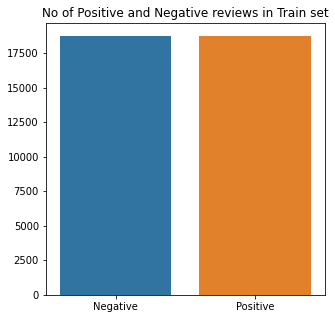

In [ ]:
v=pd.Series(y_train).value_counts()
print(v)
dd=v.values
plt.figure(figsize=(5,5))
sns.barplot(x=['Negative','Positive'],y=dd)
plt.title("No of Positive and Negative reviews in Train set")
plt.show()


PREPROCESSING A WORD TO REMOVE SPECIAL CHARACTERS AND DIGITS

In [ ]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)                       # Remove everything except letters,digits and spaces by no space 
    s = re.sub(r"\s+", '', s)                           # Replace all runs of whitespaces with no space
    s = re.sub(r"\d", '', s)                            # replace digits with no space
    return s


TOCKENIZATION OF EACH WORD IN A REVIEW 
AND REPLACE WORDS WITH ONE-HOT ENCODED VALUES IN TRAINING AND TEST SET

In [ ]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)                     
            if word not in stop_words and word != '':                                                       #REMOVING THE STOPWORDS
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    final_corpus=[]
    # tockenize
    final_list_train,final_list_test = [],[]                                                                #ONE-HOT ENCODING THE TRAIN SET
    for sent in x_train:                                                                                    
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()]) 
    
    for sent in x_train:
            final_corpus.append([preprocess_string(word) for word in sent.lower().split()                   #MAKING OF THE CORPUS
                                     if preprocess_string(word) in onehot_dict.keys()])                             
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()   #ONE-HOT ENCODING THE TEST SET
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict,final_corpus

In [ ]:
X_train,y_train,X_test,y_test,vocab,corpus = tockenize(X_train,y_train,X_test,y_test)

In [ ]:
print(corpus[1])                 #corpus is the corpus of the training set

['main', 'reason', 'see', 'flick', 'never', 'became', 'store', 'may', 'never', 'known', 'every', 'scene', 'shes', 'directed', 'piece', 'cast', 'first', 'rate', 'robert', 'especially', 'memorable']


In [ ]:
print(X_train[0])                #one hot encoded training 

[267, 230, 47, 312, 249, 270, 353, 17, 4, 148, 322, 99, 44, 420, 497, 110, 15, 174, 5, 45, 202, 192, 536, 1, 1, 336, 253, 3, 30, 392, 133, 9, 720, 3, 1, 10, 18, 64, 6, 989, 744, 27, 89, 617, 212, 6, 191]


LENGTH OF VOCABULARY

In [ ]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


ANALYZING THE LENGTH OF REVIEWS

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


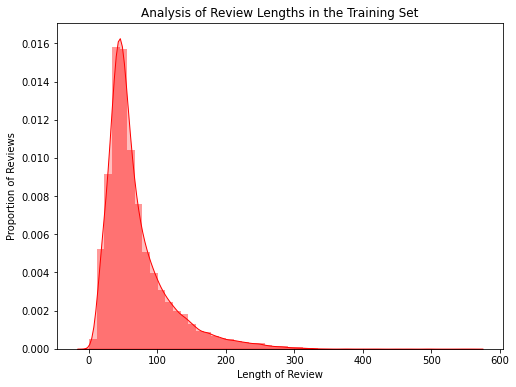

count    37500.000000
mean        69.144693
std         47.927965
min          0.000000
25%         39.000000
50%         54.000000
75%         84.000000
max        558.000000
dtype: float64

In [ ]:
review_length = [len(i) for i in X_train]
length_data=pd.Series(review_length)
plt.figure(figsize=(8,6))
sns.distplot(length_data,color='red',kde_kws={"shade":True},kde=True)
plt.title("Analysis of Review Lengths in the Training Set")
plt.xlabel("Length of Review")
plt.ylabel("Proportion of Reviews")
plt.show()
length_data.describe()

PRINTING THE FIRST REVIEW IN THE TRAINING SET AFTER TOCKENIZATION AND ENCODING

In [ ]:
print(X_train[0:3])

[list([267, 230, 47, 312, 249, 270, 353, 17, 4, 148, 322, 99, 44, 420, 497, 110, 15, 174, 5, 45, 202, 192, 536, 1, 1, 336, 253, 3, 30, 392, 133, 9, 720, 3, 1, 10, 18, 64, 6, 989, 744, 27, 89, 617, 212, 6, 191])
 list([173, 176, 11, 392, 33, 750, 977, 101, 33, 487, 75, 47, 326, 406, 302, 86, 20, 967, 475, 156, 743])
 list([139, 574, 201, 850, 229, 319, 202, 625, 319, 819, 131, 46, 4, 319, 885, 466, 493, 246, 220, 196, 819, 311, 493, 363, 70, 6, 27, 869, 5, 885, 27, 576, 42, 163, 41, 102, 76, 490, 6, 7, 65, 64, 4, 869, 648, 908, 17, 77, 360, 300, 3, 14, 510, 2, 20, 836, 222, 645, 49, 634, 839, 510, 576, 118, 619, 335, 109])]


In [ ]:
print(y_train)

[0 1 1 ... 1 1 1]


In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
print(X_test)

[list([16, 143, 3, 179, 19, 580, 196, 36, 12, 34, 34, 65, 3, 101, 208, 362, 279, 60, 567, 366, 173, 992, 2, 2, 792, 16, 38, 196, 474, 738, 16, 73, 3, 501, 729, 17, 66, 272, 272, 23, 323, 272, 38, 104, 446, 606, 373, 65, 2, 101, 184, 623, 514, 82, 11, 52, 16, 691])
 list([39, 70, 76, 22, 822, 692, 32, 79, 264, 369, 168, 9, 195, 11, 4, 25, 147, 102, 481, 727, 128, 14, 98, 454, 54, 968, 146, 54, 554, 4, 452, 3, 10, 10, 18, 63, 808, 976, 15, 40, 602, 27, 112, 18, 38, 18, 81, 10, 199, 34, 704, 942, 317, 369, 216, 28, 744, 314, 3, 7, 858, 27, 3, 51, 7, 21, 4, 571, 28, 3, 56, 7, 600, 18, 57, 261, 81, 4, 57, 550, 618, 31, 59, 828, 13, 570, 3, 75, 9, 433, 182, 52, 323, 4, 342, 761, 641, 254, 79, 379, 4, 254, 356, 190, 522, 4, 199, 18, 3, 148, 692, 90, 68, 223, 140, 6, 787, 705])
 list([287, 4, 688, 19, 101, 4, 5, 268, 147, 169, 693, 726, 66, 490, 142, 748, 30, 458, 78, 284, 6, 78, 24, 6, 592, 133, 63, 510])
 ...
 list([3, 287, 678, 234, 798, 22, 819, 252, 185, 587, 836, 252, 625, 252, 111, 182,

In [ ]:
print(y_test)

[1 0 1 ... 1 1 0]


PADDING

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [ ]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.                             #PADDING TO LENGTH 500
x_train_pad = padding_(X_train,500)
x_test_pad = padding_(X_test,500)

BATCHING AND LOADING AS TENSOR

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50                 #Batchsize=50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

LOOKING AT ONE SAMPLE BATCH OF TRAINING DATA

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Input size of a random batch of size 50 and length 500:', sample_x.size())         # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Input size of a random batch of size 50 and length 500: torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 859,   9,  58],
        [  0,   0,   0,  ..., 157, 279, 168],
        [  0,   0,   0,  ...,   2,   1, 300],
        ...,
        [  0,   0,   0,  ...,   3, 597, 167],
        [  0,   0,   0,  ...,  48,   5, 103],
        [  0,   0,   0,  ..., 107,  78, 365]])
Sample output: 
 tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0])


TRAINING OUR CORPUS USING WORD2VEC

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model1 = Word2Vec(sentences=corpus, window=5, min_count=1, workers=4)    #Embedding dimensions 100
model1.save("word2vec.model")




LOOKING AT A WORD EMBEDDING OF A WORD IN WORD2VEC

In [ ]:
vector = model1.wv['br']
print(vector)

[ 0.20113817  0.2596256   0.02847062  0.16468903 -0.50775373  0.00326226
 -0.54313153 -0.25037336  0.31023625  0.15426728  0.0984026  -0.44321266
  0.71274626 -0.29669058 -0.1333692  -0.31388274 -0.1898986  -0.57883567
  0.06252825 -0.8289392  -0.04081862  0.1708844   0.16959925  0.2443683
 -0.7343311   0.02379784 -0.25031027  0.5044533   0.15844686  0.11310621
 -0.04147642  0.151375   -0.4915913   0.3315909   0.06221532  0.77861315
  0.3932544  -0.35125238 -0.4853598  -0.31570196  0.09559932  0.5843627
 -0.14215545  0.01343707  0.3282927   0.17909993  0.12182486 -0.1259974
 -0.72682685  0.12581041  0.04956407 -0.11312543 -0.39942005  0.6310883
 -0.5614767   0.02568071 -0.0993187  -0.33216807 -0.5921148  -0.23900828
 -0.10494468 -0.08404949  0.44807178  0.5503622   0.32398087 -0.3767919
 -0.42693463  0.14789028  0.42514494  0.03044885 -0.30427536 -0.8287477
  0.8044161  -0.34888634 -0.3905042   0.25375858  0.23275928 -0.09296945
 -0.7835027   0.5648758   0.3106166   0.10210003  0.32718

VISUALIZATION OF THE WORD2VEC MODEL

1. LOOKING AT WORDS MOST SIMILAR TO THE WORD "GOOD"

In [ ]:
model1.most_similar('good')[:5]                     #finding 5 most similar words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('decent', 0.7306317090988159),
 ('bad', 0.6334047317504883),
 ('great', 0.5555548667907715),
 ('ok', 0.5332280397415161),
 ('fine', 0.5189286470413208)]

VISUALIZING THE WORD2VEC EMBEDDINGS

In [ ]:
from sklearn.manifold import TSNE
v=list(model1.wv.vocab)
V=model1[v]
tsne = TSNE(n_components=2)
V_tsne = tsne.fit_transform(V[:200,:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


DIMENSIONALITY REDUCTION TO REPRESENT THE WORDS IN A 2D PLANE

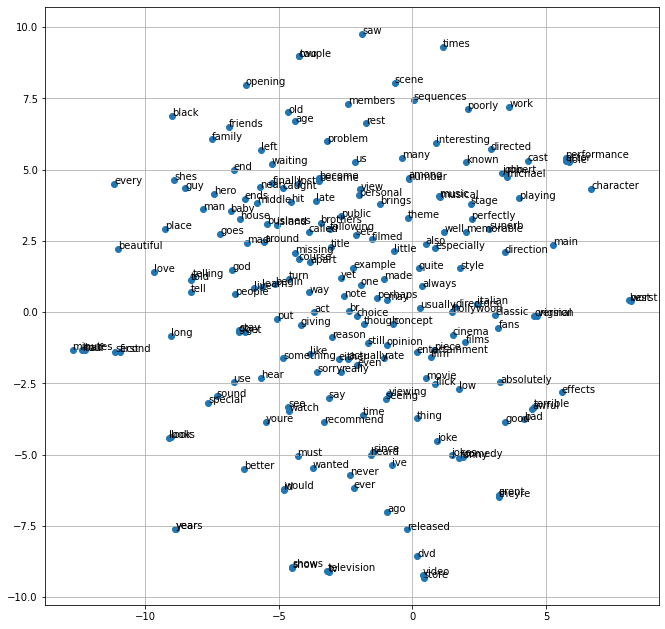

In [ ]:
vo_df = pd.DataFrame(V_tsne, index=v[:200], columns=['x', 'y'])
fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vo_df['x'], vo_df['y'])
for word, pos in vo_df.iterrows():                                             # plotting of the words in Word2vec embeddings 
    ax.annotate(word, pos)
ax.grid() 



*   As we can see in the representation above similar words have very close embeddings. For example,the words 'shows' and 'television' have very similar embeddings.Also, words like 'cast' and 'directed' have similar embeddings and so on.
*   Hence, the Word2Vec model can represent meanings of the words in our corpus.



In [ ]:
print(vocab)                    #Printing the vocabulary of our training set

{'br': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'good': 6, 'even': 7, 'would': 8, 'time': 9, 'really': 10, 'see': 11, 'story': 12, 'much': 13, 'well': 14, 'get': 15, 'great': 16, 'also': 17, 'bad': 18, 'people': 19, 'first': 20, 'dont': 21, 'movies': 22, 'make': 23, 'made': 24, 'films': 25, 'could': 26, 'way': 27, 'characters': 28, 'think': 29, 'watch': 30, 'many': 31, 'seen': 32, 'never': 33, 'two': 34, 'character': 35, 'love': 36, 'best': 37, 'acting': 38, 'know': 39, 'plot': 40, 'little': 41, 'show': 42, 'life': 43, 'ever': 44, 'better': 45, 'still': 46, 'scene': 47, 'say': 48, 'end': 49, 'man': 50, 'scenes': 51, 'something': 52, 'go': 53, 'im': 54, 'back': 55, 'real': 56, 'thing': 57, 'watching': 58, 'didnt': 59, 'doesnt': 60, 'years': 61, 'actors': 62, 'another': 63, 'actually': 64, 'though': 65, 'funny': 66, 'makes': 67, 'nothing': 68, 'find': 69, 'look': 70, 'new': 71, 'going': 72, 'work': 73, 'lot': 74, 'every': 75, 'old': 76, 'us': 77, 'part': 78, 'cant': 79, 'director':

In [ ]:
type(vocab)

dict

In [ ]:
embedding_matrix=np.zeros((len(vocab)+1,100))
embedding_matrix[0]=0                                       #EMBEDDING MATRIX having Word2VEC embeddings trained on our corpus
for word,i in vocab.items():
  embedding_matrix[i]=model.wv[word]                        # Making sure the embeddings have correct indices as our one-hot encoding indices  

In [ ]:
print(embedding_matrix[6])                                 #Printing Word2Vec embeddings for the word 6

[ 0.27829286  1.14202845 -1.13200796 -0.86615056 -0.76395261  1.16989899
 -1.14609993 -1.19067776  0.56821597 -0.3884646   0.49741602  1.36966228
  0.61211377 -0.23104851  0.13452944  0.25666571 -0.51154464 -0.46363142
  0.14835618 -0.38521487 -0.28446174  0.02626051  0.62926632  0.19693184
 -0.88400882 -0.70033866 -0.90902233 -0.53146046  1.3846029  -1.22163033
 -0.54876661 -0.43224162 -0.45322776  0.08496118  0.01889    -0.95167261
 -0.94870204 -0.37927705  0.30763432  0.07323508 -0.37643957  0.99411893
  0.94431323 -0.95819539  0.95148408  0.03729563 -0.69357562  1.23597693
 -1.20128167  0.77132756 -0.85138911  0.98196125  0.0979758   1.04486358
 -0.2286385  -0.36181802  0.23821101  0.51555794  1.65986907 -0.09941417
 -0.61362219  0.60214663  1.11685479 -0.70017648  0.57100183  0.30968165
 -0.84779936 -0.63847011 -0.01234267 -0.15935762  0.19936854  0.26782489
  0.47702986 -0.65748847 -1.76451468  1.1750468   1.59909987 -0.31306431
 -0.04076926  0.62660486  0.52035999  1.08464468  0

In [ ]:
embe=torch.FloatTensor(embedding_matrix)                    #Creating a tensor of Word2Vec embedding matrix 


In [ ]:
print(embe)                                                 #Printing the embedding matrix tensor

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4776,  0.2761,  0.1007,  ...,  0.3543, -0.1234,  0.5930],
        [-1.3413,  0.0378,  0.5118,  ..., -0.3675,  0.1101,  0.1532],
        ...,
        [ 0.0385,  0.2554, -0.4551,  ...,  1.0981,  0.3907,  0.2417],
        [-0.1208,  1.0068, -0.3401,  ..., -0.6367, -0.0090,  0.6241],
        [ 0.7406,  0.5282, -1.4153,  ..., -0.1701, -0.1665, -0.0657]])


DEFINING THE MODEL

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim                                         #OUTPUT-DIMENSIONS =1 (Probablity that it is a positive review)
        self.hidden_dim = hidden_dim                                         # hidden dim(hyperparameter no of features in h(activations))
 
        self.no_layers = no_layers                                           # NO OF LAYERS OF LSTM LAYER(STACKING) 
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding.from_pretrained(embe,freeze=True)      #USING THE PRE-TRAINED WORD2VEC EMBEDDING MATRIX
                                                                             #FREEZE=TRUE MEANS IT IS NOT PART OF LEARNING
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)                                       #USING DROPOUT BETWEEN THE LSTM LAYERS TO HELP REGULARIZATION
                                                                           
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)                     #A FULLY CONNECTED NN ON TOP OF LSTM LAYER
        self.sig = nn.Sigmoid()
         
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  
      
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim=100
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001                                                      # learning rate used

criterion = nn.BCELoss()                                      # Binary Cross Entropy loss is used

optimizer = torch.optim.Adam(model.parameters(), lr=lr)       # Using Adam optimzer for backpropagation 

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


TRAINING OF THE MODEL 

In [ ]:
clip = 5                                                       # Clipping is used to tackle problem of exploding gradients 
epochs = 7                                                     # Number of epochs
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.42932492442925774 val_loss : 0.3744488994479179
train_accuracy : 80.81866666666667 val_accuracy : 83.072
Epoch 2
train_loss : 0.38802455985546114 val_loss : 0.3843854240179062
train_accuracy : 83.08533333333334 val_accuracy : 83.312
Epoch 3
train_loss : 0.34547032276789347 val_loss : 0.3372580241858959
train_accuracy : 85.16266666666667 val_accuracy : 85.816
Epoch 4
train_loss : 0.31589344596862795 val_loss : 0.34433276736736296
train_accuracy : 86.39466666666667 val_accuracy : 85.336
Epoch 5
train_loss : 0.29188482344150546 val_loss : 0.3398723321259022
train_accuracy : 87.65066666666667 val_accuracy : 85.264
Epoch 6
train_loss : 0.2660309333205223 val_loss : 0.3316104118525982
train_accuracy : 88.75733333333334 val_accuracy : 86.048
Epoch 7
train_loss : 0.23043474942445755 val_loss : 0.3397528901696205
train_accuracy : 90.512 val_accuracy : 86.36




*   Above, we can see the training,test accuracy and loss function values over the epochs.

*  As we can see the final training accuracy is 90.5% and test accuracy is 86.36  which is quite good.

*  It was also observed that there was a significant improvement in the accuracy on using Word2Vec word embeddings. 









VISUALIZATION OF THE TRAINING AND VALIDATION ACCURACY OVER EPOCHS

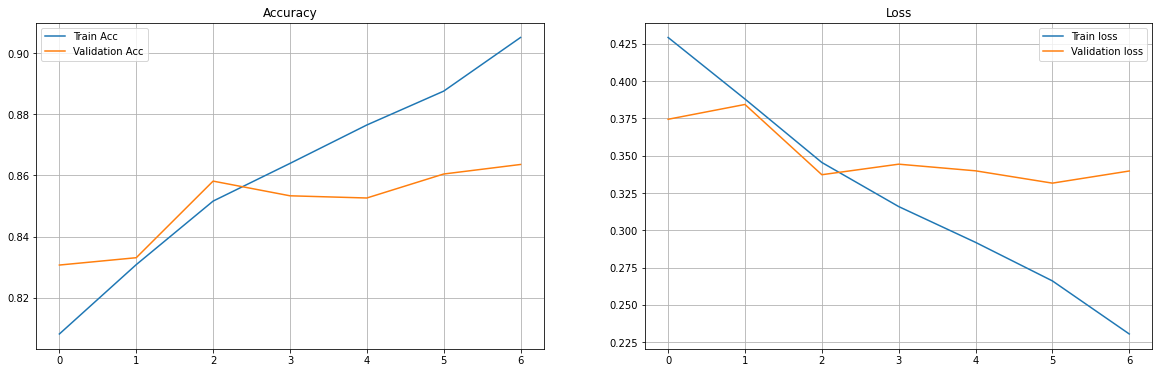

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()




*   We can see that the training and the validation accuracies increase over the number of epochs.


In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)                                                   #FUNCTION FOR PREDICTING SENTIMENT OF A RANDOM TEXT
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

PREDICTION FOR  RANDOM TEXTS ENTERED BY ME



*   A POSTIVE REVIEW



In [ ]:
print('='*70)
text="this movie was one of the world's best ones.it had a good ending and is awesome for fun time with family and friends. The climax was entralling with us gripping onto our seats"
print(text)
print(f'Actual sentiment is  Positive')
print('='*70)
pro = predict_text(text)
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

this movie was one of the world's best ones.it had a good ending and is awesome for fun time with family and friends. The climax was entralling with us gripping onto our seats
Actual sentiment is  Positive
predicted sentiment is positive with a probability of 0.9696927070617676




*   A NEGATIVE REVIEW



In [ ]:
print('='*70)
text2="What a horrible movie. It had the worst ending and the graphics was terrible. I would never watch it again"
print(text2)
print(f'Actual sentiment is  negative')
print('='*70)
pro2 = predict_text(text2)
status2 = "positive" if pro2 > 0.5 else "negative"
pro2 = (1 - pro2) if status2 == "negative" else pro2
print(f'predicted sentiment is {status2} with a probability of {pro2}')

What a horrible movie. It had the worst ending and the graphics was terrible. I would never watch it again
Actual sentiment is  negative
predicted sentiment is negative with a probability of 0.9982139711501077


 A REAL REVIEW TESTED ON THE MODEL

In [ ]:
print('='*70)
text3="Dutt is, in fact, both the strongest and weakest link in the film. In the climax scene, which has several actors coming together, he scores. Ray, not a lover of whodunits, thought denouements were long and boring, but here, Dutt keeps the audience hooked. Again, the biggest misfit in this complicated Sharadindu novel on misfits is Dutt himself, who could have done better by explaining why he was there at all and had Byomkesh chasing him at the end — is it an allegory for real life where Byomkesh, as a subject, keeps haunting him? "
print(text3)
print('='*70)
pro3 = predict_text(text3)
status3 = "positive" if pro3 > 0.5 else "negative"
pro3 = (1 - pro3) if status3 == "negative" else pro3
print(f'predicted sentiment is {status3} with a probability of {pro3}')

Dutt is, in fact, both the strongest and weakest link in the film. In the climax scene, which has several actors coming together, he scores. Ray, not a lover of whodunits, thought denouements were long and boring, but here, Dutt keeps the audience hooked. Again, the biggest misfit in this complicated Sharadindu novel on misfits is Dutt himself, who could have done better by explaining why he was there at all and had Byomkesh chasing him at the end — is it an allegory for real life where Byomkesh, as a subject, keeps haunting him? 
predicted sentiment is negative with a probability of 0.8306715488433838


THE END